In [3]:
#Sales Channel Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from datetime import date, timedelta
import scipy.stats as stats
import statsmodels.formula.api as smf
import os

pd.set_option('display.width', 1000)  # Increase max display width
pd.set_option('display.max_columns', None)  # Show all columns without wrapping
pd.set_option('display.max_rows', 200)  # Show all columns without wrapping
pd.set_option('display.colheader_justify', 'left')  # Align headers to the left

In [45]:
!jupyter nbconvert --to script Engine_Analysis.ipynb

[NbConvertApp] Converting notebook Engine_Analysis.ipynb to script
[NbConvertApp] Writing 32257 bytes to Engine_Analysis.py


In [6]:
df_sales = pd.read_csv(r"C:\Users\CharlesCorbitt\Desktop\Sales_Analyst_Sample_Data.csv")
df_sales.head(10)

,Customer_ID,Acquisition_Cost,First_Purchase_Date,Last_Purchase_Date,Total_Purchases,Average_Order_Value,Total_Revenue,Customer_Lifetime_Months,Churn_Indicator,B2B_Sales_Channel,Outreach_Date
0,CUST0001,52.998975,7/3/2022,1/1/2024,6,139.973956,839.843735,18.233333,1,Referral,5/3/2022
1,CUST0002,83.513459,11/30/2021,10/28/2024,5,34.419031,172.095154,35.433333,0,Inbound Leads,9/5/2021
2,CUST0003,35.404712,3/22/2020,11/24/2021,6,99.530067,597.180401,20.400000,1,Partnerships,1/18/2020
3,CUST0004,90.074707,5/28/2021,2/7/2022,2,49.406017,98.812033,8.500000,1,Referral,2/28/2021
4,CUST0005,41.974159,3/25/2022,2/22/2024,6,53.202629,319.215775,23.300000,0,Cold Calls,1/13/2022
5,CUST0006,6.029577,12/9/2021,7/12/2024,1,56.412911,56.412911,31.533333,0,Referral,9/25/2021
6,CUST0007,91.011288,1/15/2022,6/19/2022,8,89.607270,716.858162,5.166667,1,Cold Calls,11/19/2021
7,CUST0008,13.672234,10/19/2022,6/30/2025,4,29.207037,116.828148,32.833333,0,Partnerships,9/21/2022
8,CUST0009,35.334796,12/7/2021,3/20/2022,5,91.602819,458.014097,3.433333,1,Partnerships,10/9/2021
9,CUST0010,95.255887,4/15/2021,7/9/2021,3,112.107341,336.322021,2.833333,1,Events,3/4/2021


In [8]:
df_infl = pd.read_csv(r"C:\Users\CharlesCorbitt\Desktop\Sales_Analyst_Inflation_Data.csv")
df_infl.head(5)
#df_infl.dtypes

,year,month,inflation
0,2019,January,1.6
1,2019,February,1.5
2,2019,March,1.9
3,2019,April,2.0
4,2019,May,1.8


In [14]:
df_sales.dtypes

Customer_ID                  object
Acquisition_Cost            float64
First_Purchase_Date          object
Last_Purchase_Date           object
Total_Purchases               int64
Average_Order_Value         float64
Total_Revenue               float64
Customer_Lifetime_Months    float64
Churn_Indicator               int64
B2B_Sales_Channel            object
Outreach_Date                object
dtype: object

In [15]:
df_sales.describe()

,Acquisition_Cost,Total_Purchases,Average_Order_Value,Total_Revenue,Customer_Lifetime_Months,Churn_Indicator
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,51.491097,4.988000,108.117762,536.294200,19.030533,0.760000
std,27.913976,2.304447,52.578534,380.705727,10.247368,0.427511
min,5.440042,0.000000,20.040867,0.000000,1.100000,0.000000
25%,26.203042,3.000000,62.202378,245.685118,9.666667,1.000000
50%,50.868997,5.000000,105.550903,453.180215,19.450000,1.000000
75%,76.013027,6.000000,155.254786,755.649340,28.341667,1.000000
max,99.973179,12.000000,199.450895,2203.985820,36.433333,1.000000


In [9]:
# =====================================================
# Section 1: Data Preparation & Date Conversion
# =====================================================

# Convert the date columns to datetime format
date_cols = ['First_Purchase_Date', 'Last_Purchase_Date', 'Outreach_Date']
for col in date_cols:
    df_sales[col] = pd.to_datetime(df_sales[col], errors='coerce')  # invalid parsing becomes NaT

# =====================================================
# Section 2: Quality Assurance (QA) on Date Columns
# =====================================================

for col in date_cols:
    print(f"--- {col} ---")
    print("Data type:", df_sales[col].dtype)
    print("Earliest date:", df_sales[col].min())
    print("Latest date:", df_sales[col].max())
    print("Number of missing/invalid dates (NaT):", df_sales[col].isna().sum())
    print("Total unique dates:", df_sales[col].nunique())
    print("\n")

# =====================================================
# Section 3: Core KPI Calculations
# =====================================================

# (a) Time to First Purchase: Days from Outreach_Date to First_Purchase_Date
df_sales['Days_to_First_Purchase'] = (df_sales['First_Purchase_Date'] - df_sales['Outreach_Date']).dt.days

# (b) Calculated Average Order Value: Validate the provided 'Average_Order_Value'
df_sales['Calculated_Average_Order_Value'] = np.where(
    df_sales['Total_Purchases'] > 0,
    df_sales['Total_Revenue'] / df_sales['Total_Purchases'],
    np.nan
)

# (c) Purchase Frequency: Average number of purchases per month during the customer’s lifetime
df_sales['Purchases_Per_Month'] = np.where(
    df_sales['Customer_Lifetime_Months'] > 0,
    df_sales['Total_Purchases'] / df_sales['Customer_Lifetime_Months'],
    np.nan
)

# (d) Monthly Revenue: Average revenue per month for each customer
df_sales['Monthly_Revenue'] = np.where(
    df_sales['Customer_Lifetime_Months'] > 0,
    df_sales['Total_Revenue'] / df_sales['Customer_Lifetime_Months'],
    np.nan
)

# (e) CAC-to-Revenue Ratio: Lower is better (Acquisition cost relative to revenue)
df_sales['CAC_Revenue_Ratio'] = np.where(
    df_sales['Total_Revenue'] > 0,
    df_sales['Acquisition_Cost'] / df_sales['Total_Revenue'],
    np.nan
)

# =====================================================
# Section 4: Additional KPI Calculations
# =====================================================

# a) Churn Rate: Fraction of customers that have churned (assuming 1=churned, 0=active)
churn_rate = df_sales['Churn_Indicator'].mean()
print(f"Churn Rate: {churn_rate:.2%}")

# b) Repeat Purchase Rate: Fraction of customers with more than one purchase
repeat_purchase_rate = (df_sales['Total_Purchases'] > 1).mean()
print(f"Repeat Purchase Rate: {repeat_purchase_rate:.2%}")

# c) Average Customer Lifetime (in months)
average_lifetime = df_sales['Customer_Lifetime_Months'].mean()
print(f"Average Customer Lifetime (months): {average_lifetime:.2f}")

# d) LTV-to-CAC Ratio: Using Total_Revenue as Lifetime Value (LTV)
df_sales['LTV_CAC_Ratio'] = np.where(
    df_sales['Acquisition_Cost'] > 0,
    df_sales['Total_Revenue'] / df_sales['Acquisition_Cost'],
    np.nan
)
average_LTV_CAC = df_sales['LTV_CAC_Ratio'].mean()
print(f"Average LTV/CAC Ratio: {average_LTV_CAC:.2f}")

# e) Average Acquisition Cost per Customer
average_CAC = df_sales['Acquisition_Cost'].mean()
print(f"Average Acquisition Cost: {average_CAC:.2f}")

# =====================================================
# Section 5: Seasonality Variables
# =====================================================

# Add Quarter column based on Outreach_Date (assuming calendar and fiscal year are the same)
df_sales['Quarter'] = df_sales['Outreach_Date'].dt.quarter

# =====================================================
# Section 6: Holiday Flag Calculation
# =====================================================

def get_thanksgiving(year):
    """
    Calculate Thanksgiving date (the fourth Thursday in November) for a given year.
    """
    d = date(year, 11, 1)
    while d.weekday() != 3:  # 3 corresponds to Thursday
        d += timedelta(days=1)
    thanksgiving = d + timedelta(weeks=3)
    return thanksgiving

def get_week_range(target_date):
    """
    Given a date, return the Monday and Sunday of that week.
    """
    monday = target_date - timedelta(days=target_date.weekday())
    sunday = monday + timedelta(days=6)
    return monday, sunday

def is_holiday(outreach_ts):
    """
    Determine if a given outreach date (as a Timestamp) falls within any of the defined holiday weeks.
    Holiday weeks are defined as:
      - The week containing Thanksgiving (fourth Thursday in November)
      - The week containing Christmas (December 25)
      - The week containing New Year's Day
    """
    if pd.isnull(outreach_ts):
        return False
    
    outreach_date = outreach_ts.date()
    year = outreach_date.year

    # Thanksgiving Week
    thanksgiving_date = get_thanksgiving(year)
    thx_monday, thx_sunday = get_week_range(thanksgiving_date)

    # Christmas Week
    christmas_date = date(year, 12, 25)
    christmas_monday, christmas_sunday = get_week_range(christmas_date)

    # New Year's Week: Use current year's New Year's Day if in January, else next year's
    if outreach_date.month == 1:
        new_year_date = date(year, 1, 1)
    else:
        new_year_date = date(year + 1, 1, 1)
    newyear_monday, newyear_sunday = get_week_range(new_year_date)
    
    # Check if outreach_date falls within any holiday week
    if thx_monday <= outreach_date <= thx_sunday:
        return True
    if christmas_monday <= outreach_date <= christmas_sunday:
        return True
    if newyear_monday <= outreach_date <= newyear_sunday:
        return True

    return False

# Apply the holiday flag calculation based on Outreach_Date
df_sales['Holiday_Flag'] = df_sales['Outreach_Date'].apply(is_holiday)

# Quick QA: Display a sample of the Outreach_Date, Quarter, and Holiday_Flag columns


# =====================================================
# Section 7: Aggregated Metrics by Sales Channel
# =====================================================

channel_metrics = df_sales.groupby('B2B_Sales_Channel').agg({
    'Total_Revenue': ['sum', 'mean'],
    'Acquisition_Cost': ['sum', 'mean'],
    'Total_Purchases': 'sum',
    'Calculated_Average_Order_Value': 'mean',
    'Days_to_First_Purchase': 'mean',
    'Customer_Lifetime_Months': 'mean'
}).reset_index()


--- First_Purchase_Date ---
Data type: datetime64[ns]
Earliest date: 2020-01-02 00:00:00
Latest date: 2022-12-23 00:00:00
Number of missing/invalid dates (NaT): 0
Total unique dates: 397


--- Last_Purchase_Date ---
Data type: datetime64[ns]
Earliest date: 2020-04-10 00:00:00
Latest date: 2025-09-05 00:00:00
Number of missing/invalid dates (NaT): 0
Total unique dates: 439


--- Outreach_Date ---
Data type: datetime64[ns]
Earliest date: 2019-10-09 00:00:00
Latest date: 2022-12-05 00:00:00
Number of missing/invalid dates (NaT): 0
Total unique dates: 403


Churn Rate: 76.00%
Repeat Purchase Rate: 93.80%
Average Customer Lifetime (months): 19.03
Average LTV/CAC Ratio: 17.77
Average Acquisition Cost: 51.49


In [10]:
# -------------------------------------------
# 1. Check for First Purchase Date occurring BEFORE Outreach Date
# -------------------------------------------
issue_first_purchase = df_sales[df_sales['First_Purchase_Date'] < df_sales['Outreach_Date']]
count_issue_first_purchase = issue_first_purchase.shape[0]
print("Count of rows where First_Purchase_Date occurs before Outreach_Date:", count_issue_first_purchase)

# -------------------------------------------
# 2. Check for Last Purchase Date occurring BEFORE First Purchase Date
# -------------------------------------------
issue_last_purchase = df_sales[df_sales['Last_Purchase_Date'] < df_sales['First_Purchase_Date']]
count_issue_last_purchase = issue_last_purchase.shape[0]
print("Count of rows where Last_Purchase_Date occurs before First_Purchase_Date:", count_issue_last_purchase)

# -------------------------------------------
# 3. Check for any Date Columns with Future Dates
# -------------------------------------------
today = pd.Timestamp.today()

for col in date_cols:
    future_count = df_sales[df_sales[col] > today].shape[0]
    print(f"Count of rows where {col} is in the future: {future_count}")

# Define your hardcoded cutoff date (adjust the date string as needed)
cutoff_date = pd.Timestamp('2025-01-31')

# Filter records where Last_Purchase_Date is beyond the cutoff date
future_records = df_sales[df_sales['Last_Purchase_Date'] > cutoff_date]

# Group the filtered records by channel and count them
counts_by_channel = future_records.groupby('B2B_Sales_Channel').size().reset_index(name='Count')

# Display the counts by channel
print("Counts of records with Last_Purchase_Date after the cutoff date by channel:")
print(counts_by_channel)


Count of rows where First_Purchase_Date occurs before Outreach_Date: 0
Count of rows where Last_Purchase_Date occurs before First_Purchase_Date: 0
Count of rows where First_Purchase_Date is in the future: 0
Count of rows where Last_Purchase_Date is in the future: 29
Count of rows where Outreach_Date is in the future: 0
Counts of records with Last_Purchase_Date after the cutoff date by channel:
  B2B_Sales_Channel  Count
0     Cold Calls     6    
1         Events     2    
2  Inbound Leads     6    
3   Partnerships     7    
4       Referral     8    


In [11]:
# Define your hardcoded cutoff date (adjust the date string as needed)
cutoff_date = pd.Timestamp('2025-01-31')  # Example cutoff date

# Filter df_sales_merged to only include rows where Last_Purchase_Date is on or before the cutoff_date
df_sales = df_sales[df_sales['Last_Purchase_Date'] <= cutoff_date]

# Optional: Print the shape to verify that the records have been dropped
print("Shape after dropping records with Last_Purchase_Date beyond the cutoff date:", df_sales.shape)

Shape after dropping records with Last_Purchase_Date beyond the cutoff date: (471, 19)


In [195]:
df_sales.head(5)

,Customer_ID,Acquisition_Cost,First_Purchase_Date,Last_Purchase_Date,Total_Purchases,Average_Order_Value,Total_Revenue,Customer_Lifetime_Months,Churn_Indicator,B2B_Sales_Channel,Outreach_Date,Days_to_First_Purchase,Calculated_Average_Order_Value,Purchases_Per_Month,Monthly_Revenue,CAC_Revenue_Ratio,LTV_CAC_Ratio,Quarter,Holiday_Flag,year,month_num
0,CUST0001,52.998975,2022-07-03,2024-01-01,6,139.973956,839.843735,18.233333,1,Referral,2022-05-03,61,139.973956,0.329068,46.060900,0.063106,15.846415,2,False,2022,5
1,CUST0002,83.513459,2021-11-30,2024-10-28,5,34.419031,172.095154,35.433333,0,Inbound Leads,2021-09-05,86,34.419031,0.141110,4.856872,0.485275,2.060688,3,False,2021,9
2,CUST0003,35.404712,2020-03-22,2021-11-24,6,99.530067,597.180401,20.400000,1,Partnerships,2020-01-18,64,99.530067,0.294118,29.273549,0.059286,16.867258,1,False,2020,1
3,CUST0004,90.074707,2021-05-28,2022-02-07,2,49.406017,98.812033,8.500000,1,Referral,2021-02-28,89,49.406017,0.235294,11.624945,0.911576,1.097001,1,False,2021,2
4,CUST0005,41.974159,2022-03-25,2024-02-22,6,53.202629,319.215775,23.300000,0,Cold Calls,2022-01-13,71,53.202629,0.257511,13.700248,0.131491,7.605055,1,False,2022,1


In [196]:
# Display the aggregated channel metrics
print(channel_metrics)

  B2B_Sales_Channel Total_Revenue             Monthly_Revenue Acquisition_Cost            CAC_Revenue_Ratio Customer_Lifetime_Months LTV_CAC_Ratio Total_Purchases Calculated_Average_Order_Value Days_to_First_Purchase Purchases_Per_Month Churn_Indicator inflation
                    sum           mean        mean            sum              mean       mean              mean                     mean          sum             mean                           mean                   mean                mean            mean     
0     Cold Calls     57080.355380  627.256653  60.783976       4750.783426      52.206411  0.147103          19.014286                18.754250     507             112.219373                     50.615385              0.558291            0.725275        5.219318
1         Events     50571.987522  526.791537  51.033529       5097.268215      53.096544  0.180650          17.512847                18.649727     462             110.156624                     46.833333       

In [197]:
df_sales.isnull().sum()

Customer_ID                       0
Acquisition_Cost                  0
First_Purchase_Date               0
Last_Purchase_Date                0
Total_Purchases                   0
Average_Order_Value               0
Total_Revenue                     0
Customer_Lifetime_Months          0
Churn_Indicator                   0
B2B_Sales_Channel                 0
Outreach_Date                     0
Days_to_First_Purchase            0
Calculated_Average_Order_Value    5
Purchases_Per_Month               0
Monthly_Revenue                   0
CAC_Revenue_Ratio                 5
LTV_CAC_Ratio                     0
Quarter                           0
Holiday_Flag                      0
year                              0
month_num                         0
dtype: int64

In [198]:
df_sales.describe()

,Acquisition_Cost,First_Purchase_Date,Last_Purchase_Date,Total_Purchases,Average_Order_Value,Total_Revenue,Customer_Lifetime_Months,Churn_Indicator,Outreach_Date,Days_to_First_Purchase,Calculated_Average_Order_Value,Purchases_Per_Month,Monthly_Revenue,CAC_Revenue_Ratio,LTV_CAC_Ratio,Quarter,year,month_num
count,471.000000,471,471,471.000000,471.000000,471.000000,471.000000,471.000000,471,471.000000,466.000000,471.000000,471.000000,466.000000,471.000000,471.000000,471.000000,471.000000
mean,52.299381,2021-06-10 00:51:58.471337728,2022-12-08 01:53:07.261146368,5.029724,108.820725,543.455497,18.201415,0.806794,2021-04-23 06:55:47.770700544,47.747346,108.840449,0.513605,57.469309,0.173132,17.537586,2.583864,2020.794055,6.707006
min,5.440042,2020-01-02 00:00:00,2020-04-10 00:00:00,0.000000,20.040867,0.000000,1.100000,0.000000,2019-10-09 00:00:00,7.000000,20.040867,0.000000,0.000000,0.004726,0.000000,1.000000,2019.000000,1.000000
25%,27.298376,2020-09-07 00:00:00,2022-02-21 12:00:00,3.000000,63.176321,250.355498,9.266667,1.000000,2020-07-22 12:00:00,28.000000,63.104135,0.162896,12.608838,0.051442,4.749802,2.000000,2020.000000,4.000000
50%,52.708526,2021-06-13 00:00:00,2023-01-15 00:00:00,5.000000,106.992971,456.913600,18.600000,1.000000,2021-05-08 00:00:00,48.000000,106.987372,0.266075,27.304080,0.113073,8.821990,3.000000,2021.000000,7.000000
75%,76.360912,2022-03-06 12:00:00,2023-10-05 00:00:00,7.000000,155.887901,758.032615,26.733333,1.000000,2022-01-14 12:00:00,67.000000,156.167588,0.512198,59.547214,0.207690,19.313364,4.000000,2022.000000,10.000000
max,99.973179,2022-12-21 00:00:00,2025-01-25 00:00:00,12.000000,199.450895,2203.985820,36.433333,1.000000,2022-11-08 00:00:00,89.000000,199.450895,6.250000,963.811919,1.533083,211.589918,4.000000,2022.000000,12.000000
std,27.829424,NaN,NaN,2.335473,52.556564,384.484576,9.960786,0.395233,NaN,23.608551,52.651446,0.703646,94.282033,0.214971,23.803624,1.147094,0.919092,3.507914


In [199]:
print(df_sales[['Outreach_Date', 'Quarter', 'Holiday_Flag']].head(5))

  Outreach_Date  Quarter  Holiday_Flag
0 2022-05-03     2        False       
1 2021-09-05     3        False       
2 2020-01-18     1        False       
3 2021-02-28     1        False       
4 2022-01-13     1        False       


In [200]:
df_sales.dtypes

Customer_ID                               object
Acquisition_Cost                         float64
First_Purchase_Date               datetime64[ns]
Last_Purchase_Date                datetime64[ns]
Total_Purchases                            int64
Average_Order_Value                      float64
Total_Revenue                            float64
Customer_Lifetime_Months                 float64
Churn_Indicator                            int64
B2B_Sales_Channel                         object
Outreach_Date                     datetime64[ns]
Days_to_First_Purchase                     int32
Calculated_Average_Order_Value           float64
Purchases_Per_Month                      float64
Monthly_Revenue                          float64
CAC_Revenue_Ratio                        float64
LTV_CAC_Ratio                            float64
Quarter                                    int32
Holiday_Flag                                bool
year                                       int32
month_num           

In [12]:
# -------------------------------
# Step 1: Create Year and Month Columns in df_sales
# -------------------------------
# We already have Outreach_Date as a datetime. Create 'year' and 'month_num' for merging.
df_sales['year'] = df_sales['Outreach_Date'].dt.year
df_sales['month_num'] = df_sales['Outreach_Date'].dt.month  # numeric month (1-12)

# -------------------------------
# Step 2: Prepare the Inflation Data (df_infl)
# -------------------------------
# Check if the 'month' column in df_infl is numeric; if not, try converting it.
# Assumption: If df_infl['month'] is not numeric (e.g., month names), we can map them to numbers.
if df_infl['month'].dtype == 'O':  # object type; might be month names or strings
    try:
        # Try converting directly to numeric
        df_infl['month_num'] = pd.to_numeric(df_infl['month'], errors='coerce')
        # If conversion yields many NaNs, then assume they are month names and use a mapping.
        if df_infl['month_num'].isna().sum() > 0:
            month_map = {
                'January': 1, 'February': 2, 'March': 3, 'April': 4,
                'May': 5, 'June': 6, 'July': 7, 'August': 8,
                'September': 9, 'October': 10, 'November': 11, 'December': 12
            }
            df_infl['month_num'] = df_infl['month'].map(month_map)
    except Exception as e:
        print("Error converting month in df_infl:", e)
else:
    # If already numeric, rename it for clarity.
    df_infl['month_num'] = df_infl['month']

# -------------------------------
# Step 3: Merge df_sales with df_infl on Year and Month
# -------------------------------
# We want to attach the inflation rate to each sales record based on its outreach year and month.
df_sales_merged = pd.merge(
    df_sales,
    df_infl[['year', 'month_num', 'inflation']],
    on=['year', 'month_num'],
    how='left'
)

# -------------------------------
# Step 4: Aggregated Metrics by Sales Channel (with Inflation Info)
# -------------------------------
# We now group by 'B2B_Sales_Channel' and aggregate several KPIs, including the average inflation
channel_metrics = df_sales_merged.groupby('B2B_Sales_Channel').agg({
    'Total_Revenue': ['sum', 'mean'],
    'Monthly_Revenue': 'mean',
    'Acquisition_Cost': ['sum', 'mean'],
    'CAC_Revenue_Ratio': 'mean' ,
    'Customer_Lifetime_Months': 'mean',
    'LTV_CAC_Ratio':'mean',
    'Total_Purchases': 'sum',
    'Calculated_Average_Order_Value': 'mean',
    'Days_to_First_Purchase': 'mean',
    'Purchases_Per_Month':'mean',
    'Churn_Indicator': 'mean',
    'inflation': 'mean'
}).reset_index()


In [202]:
#Quick check of the merge
print("Merged Data Sample:")
print(df_sales_merged[['Outreach_Date', 'year', 'month_num', 'inflation']].head())

Merged Data Sample:
  Outreach_Date  year  month_num  inflation
0 2022-05-03     2022  5          8.6      
1 2021-09-05     2021  9          5.4      
2 2020-01-18     2020  1          2.5      
3 2021-02-28     2021  2          1.7      
4 2022-01-13     2022  1          7.5      


In [232]:
# Export back to the desktop with a new filename
export_path = r"C:\Users\CharlesCorbitt\Desktop\Sales_Analyst_Sample_Data_Merged.csv"

if os.path.exists(export_path):
    os.remove(export_path)
    print(f"Existing file deleted: {export_path}")

df_sales_merged.to_csv(export_path, index=False)  # Save without the index column

Existing file deleted: C:\Users\CharlesCorbitt\Desktop\Sales_Analyst_Sample_Data_Merged.csv


In [223]:
# Sort channel_metrics
channel_metrics_sorted = channel_metrics.sort_values(by=('Days_to_First_Purchase', 'mean'), ascending=False)

channel_metrics_sorted

B2B_Sales_Channel Total_Revenue             Monthly_Revenue Acquisition_Cost            CAC_Revenue_Ratio Customer_Lifetime_Months LTV_CAC_Ratio Total_Purchases Calculated_Average_Order_Value Days_to_First_Purchase Purchases_Per_Month Churn_Indicator inflation
                    sum           mean        mean            sum              mean       mean              mean                     mean          sum             mean                           mean                   mean                mean            mean     
0     Cold Calls     53789.050721  632.812361  63.891615       4526.154047      53.248871  0.146217          18.065882                17.584578     483             110.754884                     50.517647              0.589080            0.776471        5.004878
2  Inbound Leads     58288.619780  577.115047  52.491829       5032.577812      49.827503  0.152321          18.979208                18.774833     506             113.212119                     49.158416              0.442412            0.762376        4.608247
1         Events     49601.211551  527.672463  51.784979       4977.677897      52.954020  0.182119          17.202482                18.825888     453             109.697986                     46.765957              0.506659            0.851064        3.933333
4       Referral     46019.485448  484.415636  51.585636       4966.968697      52.283881  0.186246          18.362456                15.521680     468             102.390176                     46.400000              0.515293            0.778947        4.678723
3   Partnerships     48269.171441  502.803869  68.407905       5129.629778      53.433644  0.197107          18.321875                16.927734     459             108.011897                     46.104167              0.526809            0.864583        3.884211

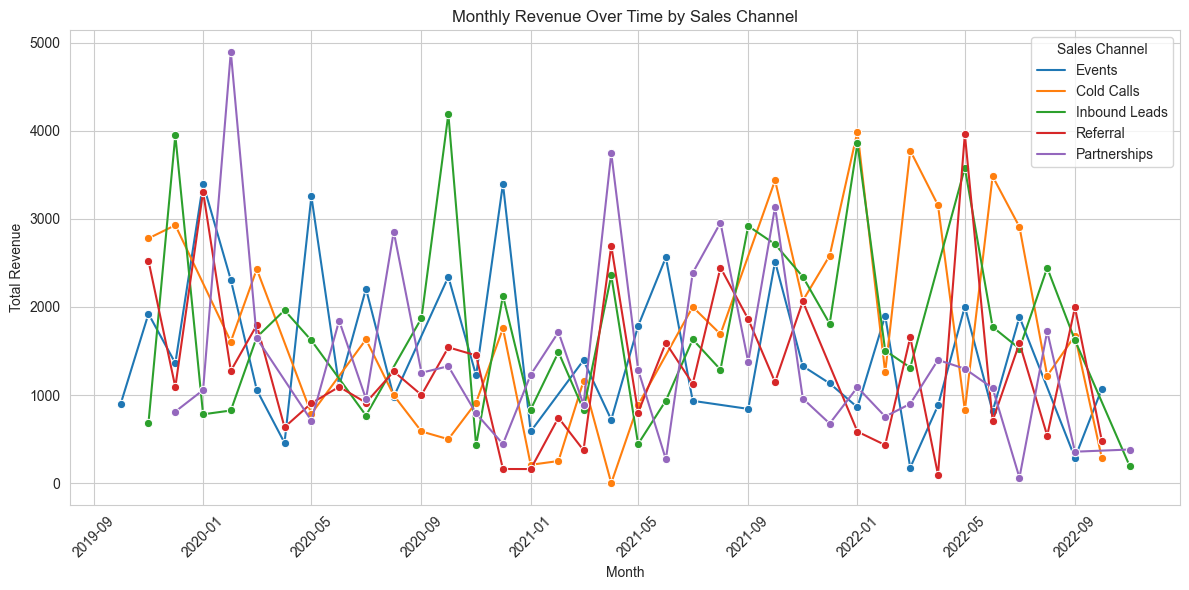

In [13]:
# Create a new column representing the first day of each month based on the 'year' and 'month_num' columns.
df_sales_merged['month_date'] = pd.to_datetime(
    df_sales_merged['year'].astype(str) + '-' + df_sales_merged['month_num'].astype(str).str.zfill(2) + '-01'
)

# Group by the new month_date and B2B_Sales_Channel, aggregating total revenue for each group.
monthly_revenue = df_sales_merged.groupby(['month_date', 'B2B_Sales_Channel'])['Total_Revenue'].sum().reset_index()

# Set the visual style (optional)
sns.set_style("whitegrid")

# Create the line plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=monthly_revenue,
    x='month_date',
    y='Total_Revenue',
    hue='B2B_Sales_Channel',
    marker='o'
)

plt.title('Monthly Revenue Over Time by Sales Channel')
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.legend(title='Sales Channel')
plt.tight_layout()
plt.show()

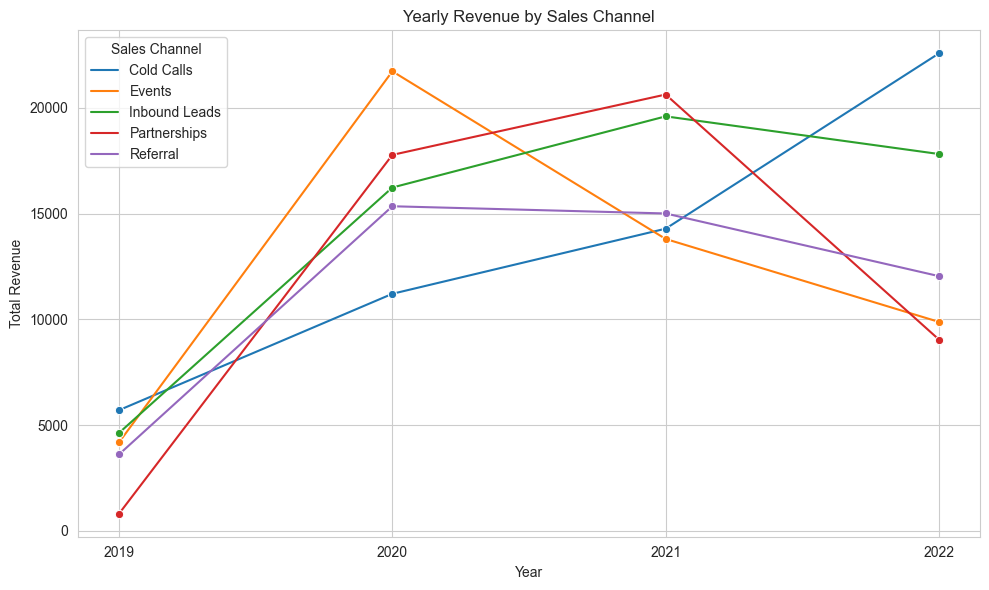

In [14]:
# Group by 'year' and 'B2B_Sales_Channel' to aggregate total revenue for each group.
yearly_revenue = df_sales_merged.groupby(['year', 'B2B_Sales_Channel'])['Total_Revenue'].sum().reset_index()

# Set a visual style
sns.set_style("whitegrid")

# Create the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=yearly_revenue,
    x='year',
    y='Total_Revenue',
    hue='B2B_Sales_Channel',
    marker='o'
)

plt.title('Yearly Revenue by Sales Channel')
plt.xlabel('Year')
plt.ylabel('Total Revenue')
plt.xticks(sorted(yearly_revenue['year'].unique()))
plt.legend(title='Sales Channel')
plt.tight_layout()
plt.show()


In [15]:
# -------------------------------
# Grouping Data: Count Outreaches by Holiday Flag and Sales Channel
# -------------------------------
outreach_counts = df_sales_merged.groupby(['B2B_Sales_Channel', 'Holiday_Flag']).size().reset_index(name='Outreach_Count')

# Optional: Display the aggregated counts
print(outreach_counts)

  B2B_Sales_Channel  Holiday_Flag  Outreach_Count
0     Cold Calls     False         80            
1     Cold Calls      True          5            
2         Events     False         90            
3         Events      True          4            
4  Inbound Leads     False         96            
5  Inbound Leads      True          5            
6   Partnerships     False         93            
7   Partnerships      True          3            
8       Referral     False         89            
9       Referral      True          6            


In [16]:
# Summarize key timing metrics by sales channel
bottleneck_summary = df_sales_merged.groupby('B2B_Sales_Channel').agg(
    avg_time_to_first_purchase = ('Days_to_First_Purchase', 'mean'),
    median_time_to_first_purchase = ('Days_to_First_Purchase', 'median'),
    std_time_to_first_purchase = ('Days_to_First_Purchase', 'std'),
    count = ('B2B_Sales_Channel', 'count')
).reset_index()

print("Bottleneck Summary by Sales Channel:")
bottleneck_summary


Bottleneck Summary by Sales Channel:


,B2B_Sales_Channel,avg_time_to_first_purchase,median_time_to_first_purchase,std_time_to_first_purchase,count
0,Cold Calls,50.517647,54.0,22.615635,85
1,Events,46.765957,48.0,24.263972,94
2,Inbound Leads,49.158416,50.0,22.862079,101
3,Partnerships,46.104167,46.0,23.607082,96
4,Referral,46.400000,45.0,24.766742,95


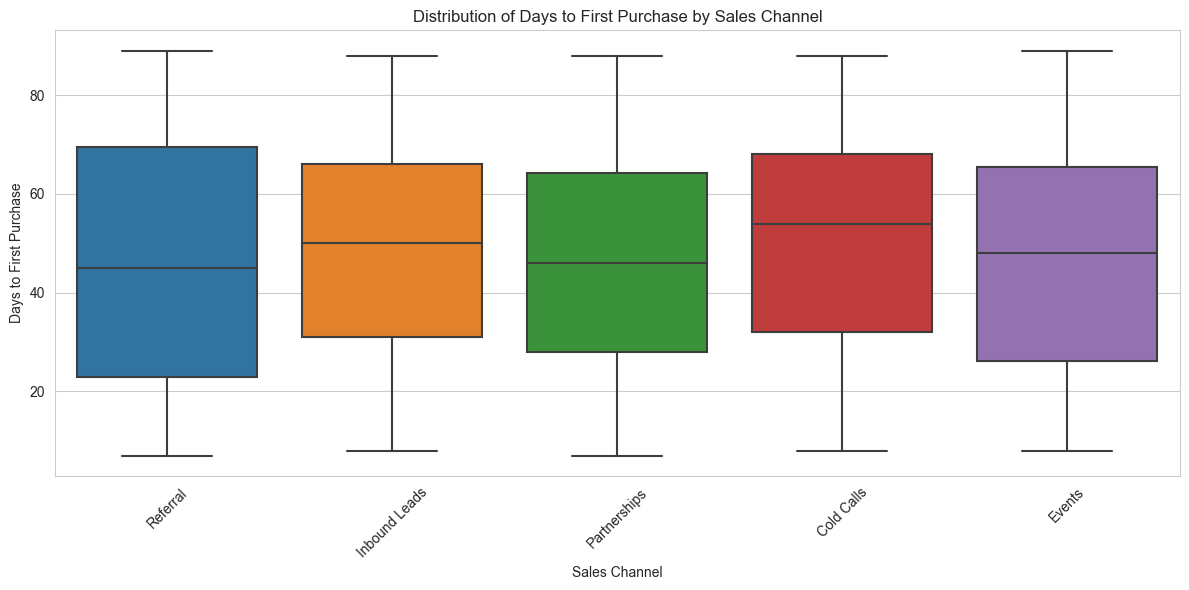

In [209]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_sales_merged,
    x='B2B_Sales_Channel',
    y='Days_to_First_Purchase'
)
plt.title('Distribution of Days to First Purchase by Sales Channel')
plt.xlabel('Sales Channel')
plt.ylabel('Days to First Purchase')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

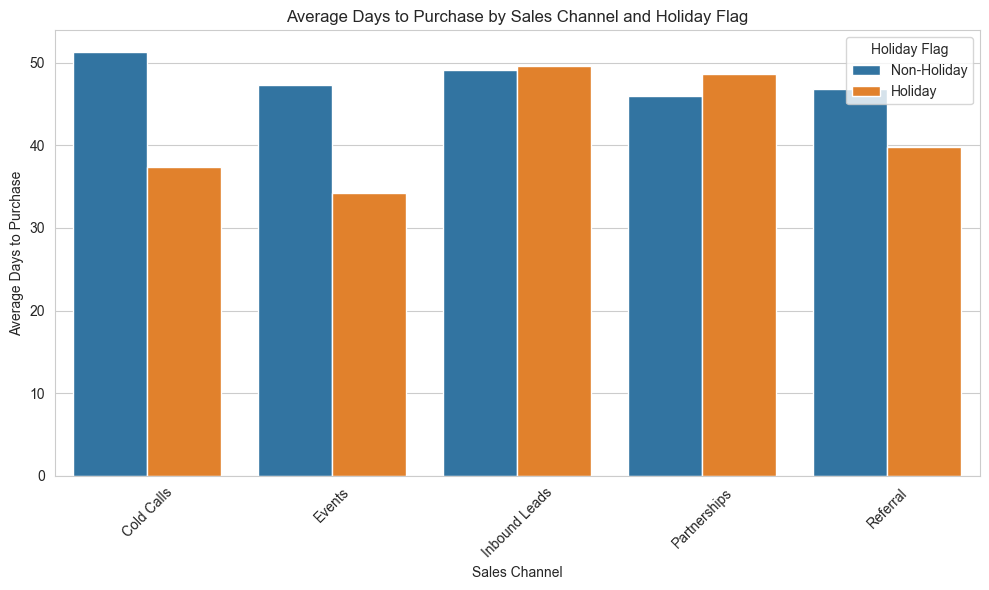

In [17]:
# Aggregate average Days_to_First_Purchase by Sales Channel and Holiday Flag
avg_days = df_sales_merged.groupby(['B2B_Sales_Channel', 'Holiday_Flag'])['Days_to_First_Purchase'].mean().reset_index()

# Optionally, map the Holiday_Flag booleans to more descriptive labels
avg_days['Holiday_Flag'] = avg_days['Holiday_Flag'].map({False: 'Non-Holiday', True: 'Holiday'})

# Create the grouped bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_days, x='B2B_Sales_Channel', y='Days_to_First_Purchase', hue='Holiday_Flag')

plt.title('Average Days to Purchase by Sales Channel and Holiday Flag')
plt.xlabel('Sales Channel')
plt.ylabel('Average Days to Purchase')
plt.xticks(rotation=45)
plt.legend(title='Holiday Flag')
plt.tight_layout()
plt.show()

In [27]:
# Drop missing values for the variables used in the logistic regression
df_logistic_channel = df_sales_merged.dropna(subset=["Churn_Indicator", "B2B_Sales_Channel"])

# Fit the logistic regression model with Referral as the reference category
logistic_model_channel = smf.logit(
    formula="Churn_Indicator ~ C(B2B_Sales_Channel, Treatment(reference='Inbound Leads'))",
    data=df_logistic_channel
).fit()

print("Logistic Regression Results (Predicting Churn using Sales Channel, with Inbound Leads as Reference):")
print(logistic_model_channel.summary())

# Calculate odds ratios for interpretation
import numpy as np
odds_ratios = np.exp(logistic_model_channel.params)
print("\nOdds Ratios:")
print(odds_ratios)

Optimization terminated successfully.
         Current function value: 0.480317
         Iterations 6
Logistic Regression Results (Predicting Churn using Sales Channel, with Inbound Leads as Reference):
                           Logit Regression Results                           
Dep. Variable:        Churn_Indicator   No. Observations:                  480
Model:                          Logit   Df Residuals:                      475
Method:                           MLE   Df Model:                            4
Date:                Sun, 09 Feb 2025   Pseudo R-squ.:                 0.01092
Time:                        12:48:24   Log-Likelihood:                -230.55
converged:                       True   LL-Null:                       -233.10
Covariance Type:            nonrobust   LLR p-value:                    0.2783
                                                                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------

In [28]:
# Exponentiate the coefficients to get the odds ratios
odds_ratios = np.exp(logistic_model_channel.params)
print("Odds Ratios:")
print(odds_ratios)

# Optionally, also get the 95% confidence intervals for the odds ratios
conf_int = logistic_model_channel.conf_int()
odds_ratios_ci = np.exp(conf_int)
odds_ratios_ci.columns = ['2.5%', '97.5%']
print("\nOdds Ratios with 95% Confidence Intervals:")
print(odds_ratios_ci)

Odds Ratios:
Intercept                                                                     3.333333
C(B2B_Sales_Channel, Treatment(reference='Inbound Leads'))[T.Cold Calls]      1.105263
C(B2B_Sales_Channel, Treatment(reference='Inbound Leads'))[T.Events]          1.735714
C(B2B_Sales_Channel, Treatment(reference='Inbound Leads'))[T.Partnerships]    1.915385
C(B2B_Sales_Channel, Treatment(reference='Inbound Leads'))[T.Referral]        1.071429
dtype: float64

Odds Ratios with 95% Confidence Intervals:
                                                    2.5%      97.5%   
Intercept                                           2.112382  5.259992
C(B2B_Sales_Channel, Treatment(reference='Inbou...  0.558820  2.186046
C(B2B_Sales_Channel, Treatment(reference='Inbou...  0.838183  3.594329
C(B2B_Sales_Channel, Treatment(reference='Inbou...  0.912465  4.020647
C(B2B_Sales_Channel, Treatment(reference='Inbou...  0.551007  2.083383


In [20]:
# -------------------------------
# Step 1: Aggregate Metrics by Channel
# -------------------------------
# Here we assume that each row in df_sales_merged represents a customer.
channel_summary = df_sales_merged.groupby("B2B_Sales_Channel").agg(
    avg_revenue = ('Total_Revenue', 'mean'),
    avg_CAC_rev = ('CAC_Revenue_Ratio', 'mean'),
    churn_rate = ('Churn_Indicator', 'mean'),
    avg_order_value = ('Calculated_Average_Order_Value', 'mean'),
    avg_days_to_first = ('Days_to_First_Purchase', 'mean')
).reset_index()

print("Channel Summary (raw metrics):")
print(channel_summary)

# -------------------------------
# Step 2: Define a Min-Max Scaling Function
# -------------------------------
def min_max_scale(series, higher_better=True):
    """Scale series values to [0,1] where 1 is best.
    If higher_better=False, lower values will get a higher score."""
    min_val = series.min()
    max_val = series.max()
    # Avoid division by zero if all values are equal:
    if max_val == min_val:
        return pd.Series(1, index=series.index)
    if higher_better:
        return (series - min_val) / (max_val - min_val)
    else:
        return (max_val - series) / (max_val - min_val)

# -------------------------------
# Step 3: Normalize Each Metric
# -------------------------------
channel_summary['score_revenue'] = min_max_scale(channel_summary['avg_revenue'], higher_better=True)
channel_summary['score_cac'] = min_max_scale(channel_summary['avg_CAC_rev'], higher_better=False)
channel_summary['score_churn'] = min_max_scale(channel_summary['churn_rate'], higher_better=False)
channel_summary['score_order_value'] = min_max_scale(channel_summary['avg_order_value'], higher_better=True)
channel_summary['score_days'] = min_max_scale(channel_summary['avg_days_to_first'], higher_better=False)

# -------------------------------
# Step 4: Compute the Composite Score
# -------------------------------
# For simplicity, we give equal weight to each metric.
channel_summary['performance_composite'] = (
    channel_summary['score_revenue'] +
    channel_summary['score_cac'] +
    channel_summary['score_churn'] +
    channel_summary['score_order_value'] +
    channel_summary['score_days']
) / 5

# -------------------------------
# Step 5: Rank the Channels Based on the Composite Score
# -------------------------------
channel_summary = channel_summary.sort_values(by='performance_composite', ascending=False)

print("\nChannel Rankings Based on Composite Performance Score:")
print(channel_summary[['B2B_Sales_Channel', 'performance_composite']])


Channel Summary (raw metrics):
  B2B_Sales_Channel  avg_revenue  avg_CAC_rev  churn_rate  avg_order_value  avg_days_to_first
0     Cold Calls     632.812361   0.146217     0.776471    110.754884       50.517647        
1         Events     527.672463   0.182119     0.851064    109.697986       46.765957        
2  Inbound Leads     577.115047   0.152321     0.762376    113.212119       49.158416        
3   Partnerships     502.803869   0.197107     0.864583    108.011897       46.104167        
4       Referral     484.415636   0.186246     0.778947    102.390176       46.400000        

Channel Rankings Based on Composite Performance Score:
  B2B_Sales_Channel  performance_composite
2  Inbound Leads     0.762537             
0     Cold Calls     0.727008             
1         Events     0.448725             
4       Referral     0.396854             
3   Partnerships     0.328677             


In [21]:
channel_summary[['B2B_Sales_Channel', 'performance_composite']]

,B2B_Sales_Channel,performance_composite
2,Inbound Leads,0.762537
0,Cold Calls,0.727008
1,Events,0.448725
4,Referral,0.396854
3,Partnerships,0.328677


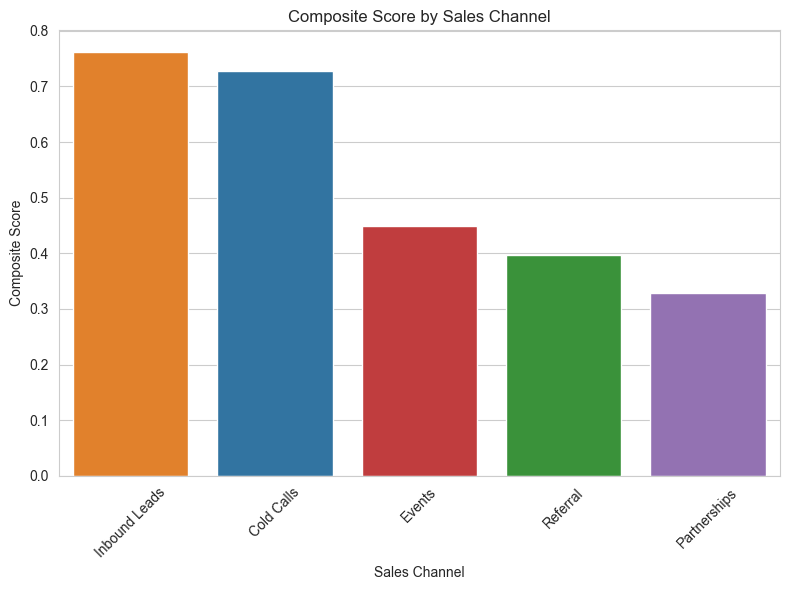

In [43]:
# Assume channel_summary is the DataFrame with composite scores,
# with columns 'B2B_Sales_Channel' and 'composite_score'.

channel_palette = {
    "Cold Calls": "#1f77b4",     # blue
    "Inbound Leads": "#ff7f0e",  # orange
    "Referral": "#2ca02c",       # green
    "Events": "#d62728",         # red
    "Partnerships": "#9467bd"    # purple
}

plt.figure(figsize=(8, 6))
sns.barplot(data=channel_summary, x='B2B_Sales_Channel', y='performance_composite', palette=channel_palette)
plt.title('Composite Score by Sales Channel')
plt.xlabel('Sales Channel')
plt.ylabel('Composite Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [22]:
# -------------------------------
# Step 1: Filter Data for Cold Calls Channel
# -------------------------------
cold_calls = df_sales_merged[df_sales_merged['B2B_Sales_Channel'] == 'Cold Calls']

# -------------------------------
# Step 2: Calculate Current Metrics for Cold Calls
# -------------------------------
n_current = cold_calls.shape[0]
current_total_revenue = cold_calls['Total_Revenue'].sum()
current_total_monthly_revenue = cold_calls['Monthly_Revenue'].sum()

# Calculate the average revenue per customer (total and monthly)
avg_revenue_per_customer = cold_calls['Total_Revenue'].mean()
avg_monthly_revenue_per_customer = cold_calls['Monthly_Revenue'].mean()

# -------------------------------
# Step 3: Simulate a 15% Increase in Customers
# -------------------------------
n_new = int(0.15 * n_current)  # Additional customers, 15% increase

# Predicted additional revenue:
additional_total_revenue = n_new * avg_revenue_per_customer
additional_monthly_revenue = n_new * avg_monthly_revenue_per_customer

# -------------------------------
# Step 4: Compute New Predicted Metrics
# -------------------------------
predicted_total_revenue = current_total_revenue + additional_total_revenue
predicted_total_monthly_revenue = current_total_monthly_revenue + additional_monthly_revenue

# -------------------------------
# Step 5: Calculate Percentage Increases
# -------------------------------
pct_increase_total_revenue = ((predicted_total_revenue - current_total_revenue) / current_total_revenue) * 100
pct_increase_total_monthly_revenue = ((predicted_total_monthly_revenue - current_total_monthly_revenue) / current_total_monthly_revenue) * 100

# -------------------------------
# Display the Results
# -------------------------------
print("Current Cold Calls Metrics:")
print(f"Number of Customers: {n_current}")
print(f"Total Revenue: ${current_total_revenue:,.2f}")
print(f"Total Monthly Revenue: ${current_total_monthly_revenue:,.2f}")

print("\nAfter a 10% Increase in Cold Calls Customers:")
print(f"Predicted Number of Customers: {n_current + n_new}")
print(f"Predicted Total Revenue: ${predicted_total_revenue:,.2f} ({pct_increase_total_revenue:.2f}% increase)")
print(f"Predicted Total Monthly Revenue: ${predicted_total_monthly_revenue:,.2f} ({pct_increase_total_monthly_revenue:.2f}% increase)")


Current Cold Calls Metrics:
Number of Customers: 85
Total Revenue: $53,789.05
Total Monthly Revenue: $5,430.79

After a 10% Increase in Cold Calls Customers:
Predicted Number of Customers: 97
Predicted Total Revenue: $61,382.80 (14.12% increase)
Predicted Total Monthly Revenue: $6,197.49 (14.12% increase)


In [23]:
# -------------------------------
# Step 1: Extract Year and Month from Last_Purchase_Date
# -------------------------------
df_sales_merged['year_lp'] = df_sales_merged['Last_Purchase_Date'].dt.year
df_sales_merged['month_num_lp'] = df_sales_merged['Last_Purchase_Date'].dt.month

# -------------------------------
# Step 2: Prepare the Inflation Data for Last_Purchase_Date
# -------------------------------
# Check if the 'month' column in df_infl is non-numeric (e.g., month names)
if df_infl['month'].dtype == 'O':
    # Map month names to numbers
    month_map = {
        'January': 1, 'February': 2, 'March': 3, 'April': 4,
        'May': 5, 'June': 6, 'July': 7, 'August': 8,
        'September': 9, 'October': 10, 'November': 11, 'December': 12
    }
    df_infl['month_num'] = df_infl['month'].map(month_map)
else:
    # If already numeric, convert to numeric type explicitly
    df_infl['month_num'] = pd.to_numeric(df_infl['month'], errors='coerce')

# Create a version of the inflation DataFrame for Last_Purchase_Date merging,
# renaming the columns to match our keys and to differentiate the inflation data.
df_infl_lp = df_infl[['year', 'month_num', 'inflation']].rename(
    columns={'year': 'year_lp', 'month_num': 'month_num_lp', 'inflation': 'inflation_lp'}
)

# -------------------------------
# Step 3: Merge the Inflation Data Based on Last_Purchase_Date
# -------------------------------
df_sales_merged = pd.merge(
    df_sales_merged,
    df_infl_lp,
    on=['year_lp', 'month_num_lp'],
    how='left'
)

In [230]:
print(df_sales_merged[['Last_Purchase_Date', 'year_lp', 'month_num_lp', 'inflation_lp']].head(10))

  Last_Purchase_Date  year_lp  month_num_lp  inflation_lp
0 2024-01-01          2024      1            3.9         
1 2024-10-28          2024     10            3.3         
2 2021-11-24          2021     11            6.8         
3 2022-02-07          2022      2            7.9         
4 2024-02-22          2024      2            3.8         
5 2024-07-12          2024      7            3.2         
6 2022-06-19          2022      6            9.1         
7 2022-03-20          2022      3            8.5         
8 2021-07-09          2021      7            5.4         
9 2023-02-18          2023      2            5.5         


C:\Users\CharlesCorbitt\miniconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


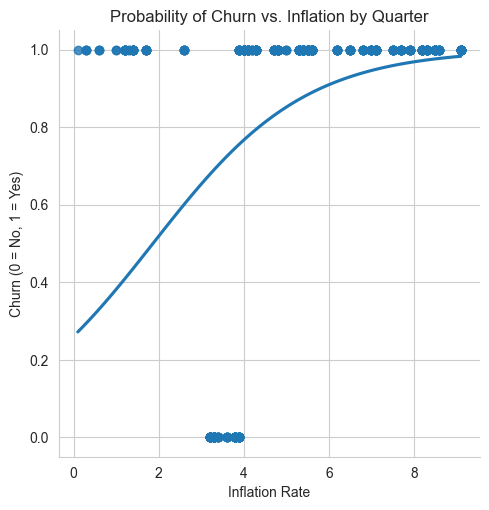

In [24]:
# Ensure Quarter is treated as a categorical variable
df_sales_merged['Quarter'] = df_sales_merged['Last_Purchase_Date'].dt.quarter.astype(str)

sns.lmplot(
    x="inflation_lp", 
    y="Churn_Indicator", 
    
    #hue="Quarter",       # Color-code points by quarter
    data=df_sales_merged, 
    logistic=True,       # Fit a logistic regression curve
    ci=None,             # Disable confidence interval shading for clarity
    #markers=["o", "x", "s", "D"],  # Different markers for each quarter
    #palette="Set1"
    
)

plt.title("Probability of Churn vs. Inflation by Quarter")
plt.xlabel("Inflation Rate")
plt.ylabel("Churn (0 = No, 1 = Yes)")
plt.show()

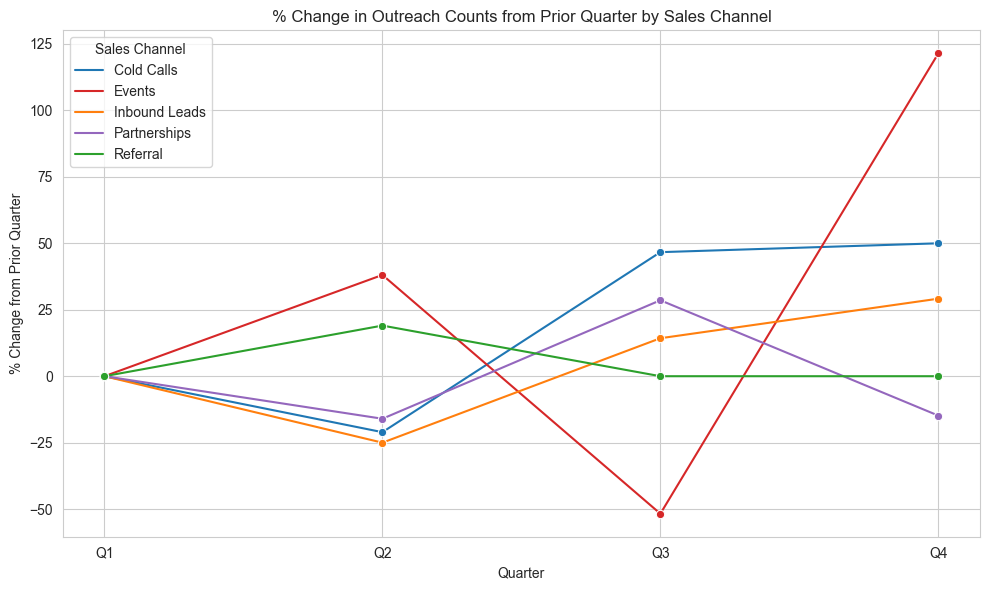

In [44]:
# -------------------------------
# 1. Create a Quarter Column from Outreach_Date (ignoring year)
# -------------------------------
df_sales_merged['Quarter'] = "Q" + df_sales_merged['Outreach_Date'].dt.quarter.astype(str)

# -------------------------------
# 2. Aggregate Outreach Counts by Quarter and Sales Channel
# -------------------------------
outreach_counts = df_sales_merged.groupby(['Quarter', 'B2B_Sales_Channel']).size().reset_index(name='Outreach_Count')

# -------------------------------
# 3. Sort the Quarter Categories in the Correct Order
# -------------------------------
quarter_order = ["Q1", "Q2", "Q3", "Q4"]
outreach_counts['Quarter'] = pd.Categorical(outreach_counts['Quarter'], categories=quarter_order, ordered=True)
outreach_counts = outreach_counts.sort_values('Quarter')

# -------------------------------
# 4. Calculate the Percentage Change from the Prior Quarter for Each Channel
# -------------------------------
# Group by channel and compute percentage change
outreach_counts['Pct_Change'] = outreach_counts.groupby('B2B_Sales_Channel')['Outreach_Count'].pct_change() * 100

# Optionally, fill NaN (which appear for the first quarter of each channel) with 0
outreach_counts['Pct_Change'] = outreach_counts['Pct_Change'].fillna(0)

# -------------------------------
# 5. Visualize the Percentage Change as a Line Graph
# -------------------------------
channel_palette = {
    "Cold Calls": "#1f77b4",     # blue
    "Inbound Leads": "#ff7f0e",  # orange
    "Referral": "#2ca02c",       # green
    "Events": "#d62728",         # red
    "Partnerships": "#9467bd"    # purple
}

plt.figure(figsize=(10, 6))
sns.lineplot(data=outreach_counts, x='Quarter', y='Pct_Change', hue='B2B_Sales_Channel', marker='o', palette=channel_palette)
plt.title("% Change in Outreach Counts from Prior Quarter by Sales Channel")
plt.xlabel("Quarter")
plt.ylabel("% Change from Prior Quarter")
plt.legend(title='Sales Channel')
plt.tight_layout()
plt.show()


In [29]:
# -------------------------------
# Step 1: Aggregate Channel Metrics for Total_Revenue
# -------------------------------
channel_metrics = df_sales_merged.groupby('B2B_Sales_Channel').agg({
    'Total_Revenue': ['sum', 'mean']
}).reset_index()

# Flatten the multi-level column names
channel_metrics.columns = ['B2B_Sales_Channel', 'Total_Revenue_sum', 'Total_Revenue_mean']

# -------------------------------
# Step 2: Calculate Average Churn Rate per Channel
# -------------------------------
channel_churn = (df_sales_merged.groupby('B2B_Sales_Channel')['Churn_Indicator']
                 .mean()
                 .reset_index()
                 .rename(columns={'Churn_Indicator': 'avg_churn_rate'}))

# Merge the churn rate into channel_metrics
channel_metrics = pd.merge(channel_metrics, channel_churn, on='B2B_Sales_Channel', how='left')

# -------------------------------
# Step 3: Determine Baseline and Scaling for Revenue Drop
# -------------------------------
# Define baseline drop (15%) when a channel's churn equals the overall average.
baseline_drop = 0.15
# Scaling factor: For each unit difference in churn, adjust the drop by 50%
scaling_factor = 0.5

# Compute overall average churn rate across the dataset.
overall_avg_churn = df_sales_merged['Churn_Indicator'].mean()
print("Overall Average Churn Rate:", overall_avg_churn)

# -------------------------------
# Step 4: Compute a Data-Backed Drop Percentage for Each Channel
# -------------------------------
def calculate_drop(row):
    # Adjust drop based on how far the channel's churn is from the overall average.
    drop = baseline_drop + scaling_factor * (row['avg_churn_rate'] - overall_avg_churn)
    # Clip the drop between 5% and 25%
    drop = np.clip(drop, 0.05, 0.25)
    return drop

channel_metrics['drop_percentage'] = channel_metrics.apply(calculate_drop, axis=1)

# -------------------------------
# Step 5: Simulate New Revenue Under the Budget Reduction Scenario
# -------------------------------
channel_metrics['Simulated_Revenue'] = channel_metrics['Total_Revenue_sum'] * (1 - channel_metrics['drop_percentage'])
channel_metrics['Pct_Change'] = ((channel_metrics['Simulated_Revenue'] - channel_metrics['Total_Revenue_sum']) /
                                  channel_metrics['Total_Revenue_sum']) * 100

# -------------------------------
# Step 6: Display the Results
# -------------------------------
print("Budget Reduction Simulation Results (Data-Backed):")
print(channel_metrics[['B2B_Sales_Channel', 
                       'Total_Revenue_sum', 
                       'avg_churn_rate', 
                       'drop_percentage', 
                       'Simulated_Revenue', 
                       'Pct_Change']])


Overall Average Churn Rate: 0.8104166666666667
Budget Reduction Simulation Results (Data-Backed):
  B2B_Sales_Channel  Total_Revenue_sum  avg_churn_rate  drop_percentage  Simulated_Revenue  Pct_Change
0     Cold Calls     54952.262041       0.786517        0.138050         47366.097121      -13.805009 
1         Events     50314.633280       0.852632        0.171107         41705.424373      -17.110746 
2  Inbound Leads     60766.758298       0.769231        0.129407         52903.111290      -12.940705 
3   Partnerships     48269.171441       0.864583        0.177083         39721.505665      -17.708333 
4       Referral     46499.181775       0.781250        0.135417         40202.417576      -13.541667 


In [33]:
channel_metrics_sorted = channel_metrics.sort_values(by=('Pct_Change'), ascending=False)

channel_metrics_sorted

,B2B_Sales_Channel,Total_Revenue_sum,Total_Revenue_mean,avg_churn_rate,drop_percentage,Simulated_Revenue,Pct_Change
2,Inbound Leads,60766.758298,584.295753,0.769231,0.129407,52903.111290,-12.940705
4,Referral,46499.181775,484.366477,0.781250,0.135417,40202.417576,-13.541667
0,Cold Calls,54952.262041,617.441147,0.786517,0.138050,47366.097121,-13.805009
1,Events,50314.633280,529.627719,0.852632,0.171107,41705.424373,-17.110746
3,Partnerships,48269.171441,502.803869,0.864583,0.177083,39721.505665,-17.708333


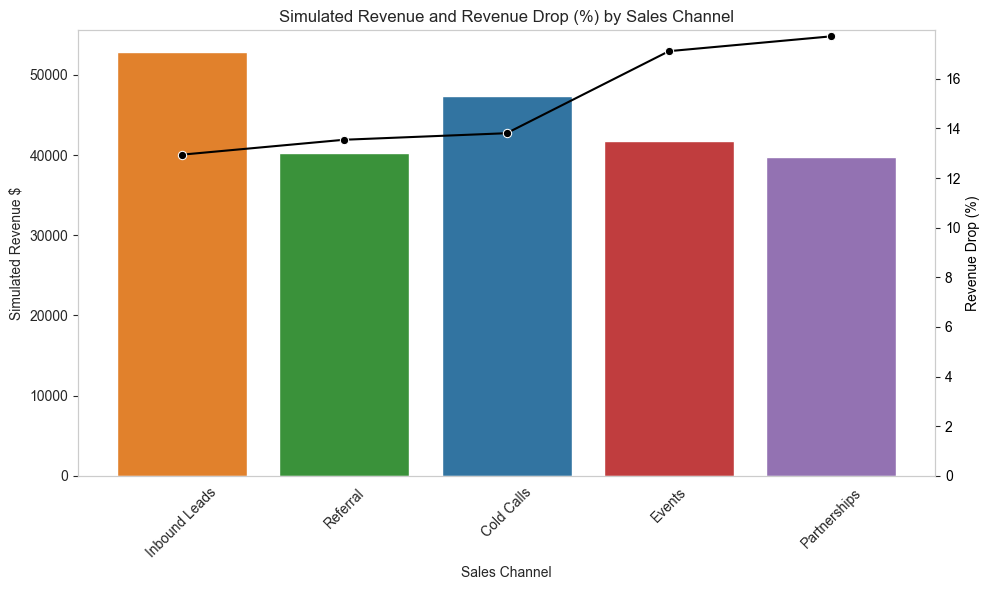

In [42]:
# Create a new column for the absolute percentage change (i.e. convert negative values to positive)
channel_metrics_sorted['Abs_Pct_Change'] = -channel_metrics_sorted['Pct_Change']

# Create the dual-axis chart
fig, ax1 = plt.subplots(figsize=(10, 6))

channel_palette = {
    "Cold Calls": "#1f77b4",     # blue
    "Inbound Leads": "#ff7f0e",  # orange
    "Referral": "#2ca02c",       # green
    "Events": "#d62728",         # red
    "Partnerships": "#9467bd"    # purple
}

# Plot Simulated_Revenue as bars on the primary y-axis
sns.barplot(
    data=channel_metrics_sorted,
    x='B2B_Sales_Channel',
    y='Simulated_Revenue',
    ax=ax1,
    palette=channel_palette  # Use our defined palette
)
ax1.set_ylabel("Simulated Revenue $")
ax1.set_xlabel("Sales Channel")
ax1.set_title("Simulated Revenue and Revenue Drop (%) by Sales Channel")
ax1.tick_params(axis='x', rotation=45)

# Create a secondary y-axis for the % change line plot
ax2 = ax1.twinx()
sns.lineplot(
    data=channel_metrics_sorted,
    x='B2B_Sales_Channel',
    y='Abs_Pct_Change',
    ax=ax2,
    marker='o',
    color='black',
    sort=False  # preserve the x-axis ordering
)
ax2.set_ylabel("Revenue Drop (%)", color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Force the secondary y-axis to start at 0
ymin, ymax = ax2.get_ylim()
ax2.set_ylim(0, ymax)

# Remove grid lines from both axes
ax1.grid(False)
ax2.grid(False)

plt.tight_layout()
plt.show()